# Project - Chronic Diseases and its Catalysts
The project is focused on looking at the top chronic diseases amongst adults in the US. 
The aim is to find the relationship between unhealthy behaviours on Obesity and Cancer to inform health professionals and general public in planning to lead a healthy lifestyle.

In [24]:
# %load import_libraries.py
#Importing libraries 
import pandas as pd
import numpy as np

from scipy.stats import zscore
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.decomposition import NMF,PCA
from sklearn.metrics import accuracy_score, r2_score
import statsmodels.api as sm
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from data_preparation import *

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.9f' % x)

# Local path to store the raw data
from get_data import get_data
path = '500cities.zip'
raw_data = get_data(path)

from eda import *
unhealthypiv,outcomespiv,data = get_unhealthy_behaviors_and_outcomes()

# Data and its Properties

500 Cities Initiative: Conducted by CDC(The Centers for Disease Control and prevention) Foundation and The Robert Wood Johnson Foundation. Provides small area estimates for chronic disease risk factors, health outcomes and clinical preventive service for the largest 500 cities in the US.
Link to download the dataset is: https://chronicdata.cdc.gov/api/views/6vp6-wxuq/rows.csv?accessType=DOWNLOAD

1. Structure of Data: Tabular Data loaded from CSV (Shape: (810103, 24))
2. Granularity: Three levels (Census Tract:782047, City: 28000, US: 56)
3. Scope: Scope is to work with 28206 rows and 34 columns of Clean Data
4. Faithfulness: Since the data is from DATA.GOV, it's reliable and Faithful.
5. Temporality: Data was last updated in 2018 

# Data Cleaning and Missing Data:

In [25]:
# Splitting the raw data into three dataframes which can be joined on UniqueID
data,df_data_definition,df_locations = create_dataframes(path)
# The code for Clean data has been written in the below function.
cleanedData = clean_data()

Count of Missing data by geographic level: 

Census Tract    336
Name: GeographicLevel, dtype: int64

Count of All data by geographic level: 

Census Tract    27204
City             1000
US                  2
Name: GeographicLevel, dtype: int64

 
 TOP AND BOTTOM 5 Cities Missing Percentage Of Censuses
                 Avg Population  Census Tracts Missing  Count  perMissing
CityName                                                                 
Santa Maria       147.000000000                      6     20 0.300000000
Fayetteville     1709.733333333                     15     69 0.217391304
Rock Hill        1762.000000000                      5     24 0.208333333
Gulfport           85.000000000                      5     24 0.208333333
Missouri City      56.750000000                      4     20 0.200000000
Abilene          1700.428571429                      7     39 0.179487179
Boca Raton       2224.000000000                      5     29 0.172413793
Miami Beach        59.00000000

# Exploratory Data Analysis (EDA)

# Correlation between Unhealthy Behaviours and possible Health Outcomes

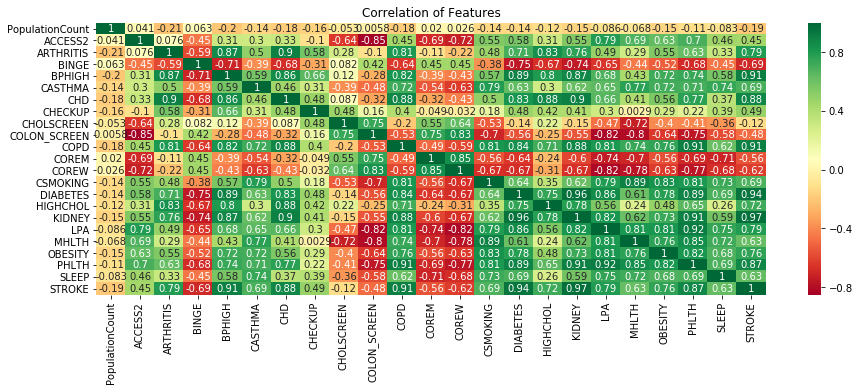

In [26]:
# %load correlation_unhealthy_outcomes.py
data = pd.read_csv('dataframes/cleaned_data.csv',index_col=0).set_index('UniqueID')
locations = pd.read_csv('dataframes/cleaned_locations.csv')
# join locations data
main = data.join(locations.set_index('UniqueID')[['GeographicLevel','StateAbbr','CityName']]).copy()

# Only keep census level data
main = main[main['GeographicLevel'] == 'Census Tract']
main = main.drop(['GeographicLevel','StateAbbr','CityName', 'DataValueTypeID'],axis=1).reset_index().set_index('UniqueID')
# Contextualy irrelevant features
#dropping data irrelevant
drop_data = np.array(['MAMMOUSE','PAPTEST','BPMED','TEETHLOST','DENTAL']) 


# Drop effects/irrelevant features
mainData = main.drop(np.concatenate([drop_data]),axis=1)
fig,ax = plt.subplots(figsize=(15,5))
sns.heatmap(mainData.drop('CANCER',axis=1).corr(),annot=True, cmap='RdYlGn')
plt.title('Correlation of Features')
plt.show()

Some inital KEY takeaways: (More Positive = More the Correlation)

1.) Looking at preventive measures such as CHOLSCREEN and BPMED, it shows a negative correlation to the health measures which means undergoing these tests is benign to us.
Exceptions - it can be seen that patients prescribed with medication for blood pressure will be already positively correlated with most of the health outcomes. This is probably because they are already taking BP medication as a result of some health issues.

2.) Binge drinking seems to be negatively correlated with all health outcomes. Which comes as a surprise. 

3.) Lack of sleep, Low physical activity, and being obese points toward being positively correlated with health outcomes, especially poor mental health, physical health, and teeth loss.

C:\Users\User\Anaconda3\envs\csenv418\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


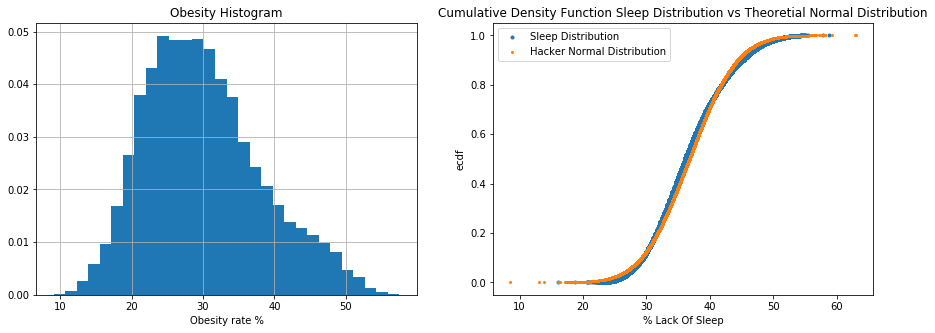

In [27]:
# %load obesity_histogram.py
fig,[ax0,ax1] = plt.subplots(1,2,figsize=(15,5))
data.OBESITY.hist(ax=ax0,bins=30,normed=True)
ax0.set_title('Obesity Histogram')
ax0.set_xlabel('Obesity rate %')

n = len(unhealthypiv.SLEEP)
x = unhealthypiv.SLEEP.sort_values()
y = np.arange(1,n+1)/n
x_theor = sorted(np.random.normal(x.mean(),x.std(),n))
ax1.plot(x,y,marker='.',linestyle='none',label='Sleep Distribution')
ax1.plot(x_theor,y,marker='.',linestyle='none',label='Hacker Normal Distribution',markersize=4)
plt.xlabel('% Lack Of Sleep')
plt.ylabel('ecdf')
plt.title('Cumulative Density Function Sleep Distribution vs Theoretial Normal Distribution')
plt.legend()
plt.show()

This histogram of obesity for the entire population is not normally distributed and has a slightly right skewed.

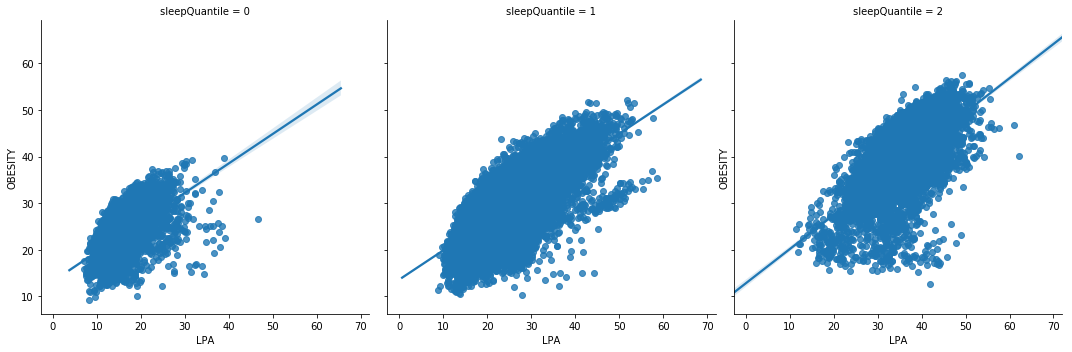

In [28]:
# %load sleep_quantiles.py
## Define whether or not a certain sleep % falls within best 20%, worst 20%, or in the middle
def quant(x,y):
    if x < y[.2]:
        return 0
    elif x > y[.8]:
        return 2
    return 1

data['sleepQuantile'] = data.SLEEP.apply(lambda x: quant(x,data.SLEEP.quantile([.2,.8])))
data['lpaQuantile'] = data.LPA.apply(lambda x: quant(x,data.LPA.quantile([.2,.8])))
data['csmokingQuantile'] = data.CSMOKING.apply(lambda x: quant(x,data.CSMOKING.quantile([.2,.8])))

#Plt the scatter plot of Low physical activity and Obesity separated by sleep quantiles
sns.lmplot('LPA','OBESITY',data=data,col='sleepQuantile')
_ = plt.xlabel('LPA')
_ = plt.ylabel('OBESITY')
plt.show()

In LPA vs Obesity and Sleep, there is a linear correlation. This means less sleep effects high Obesity.

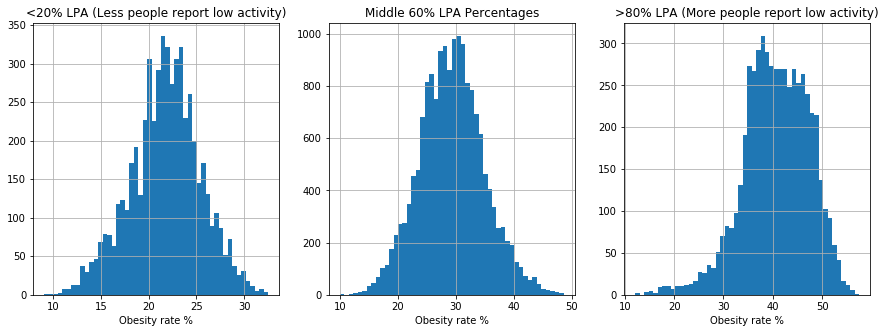

In [29]:
# %load obesity_LPA_hist.py
fig, [ax0,ax1,ax2] = plt.subplots(1,3,figsize=(15,5))

data[data['lpaQuantile']==0]['OBESITY'].hist(bins=50,ax=ax0)
ax0.set_title('<20% LPA (Less people report low activity)')
ax0.set_xlabel('Obesity rate %')
data[data['lpaQuantile']==1]['OBESITY'].hist(bins=50,ax=ax1)
ax1.set_title('Middle 60% LPA Percentages')
ax1.set_xlabel('Obesity rate %')
data[data['lpaQuantile']==2]['OBESITY'].hist(bins=50,ax=ax2)
ax2.set_title('>80% LPA (More people report low activity)')
ax2.set_xlabel('Obesity rate %')
plt.show()

We also plotted histograms between obesity rate and the two parameters we are focusing on- Low Physical Activity and Sleep.

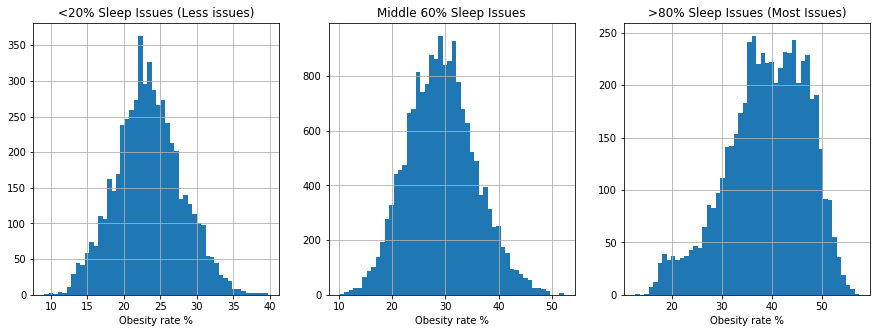

In [30]:
# %load obesity_sleep_hist.py
fig, [ax0,ax1,ax2] = plt.subplots(1,3,figsize=(15,5))

data[data['sleepQuantile']==0]['OBESITY'].hist(bins=50,ax=ax0)
ax0.set_title('<20% Sleep Issues (Less issues)')
ax0.set_xlabel('Obesity rate %')
data[data['sleepQuantile']==1]['OBESITY'].hist(bins=50,ax=ax1)
ax1.set_title('Middle 60% Sleep Issues')
ax1.set_xlabel('Obesity rate %')
data[data['sleepQuantile']==2]['OBESITY'].hist(bins=50,ax=ax2)
ax2.set_title('>80% Sleep Issues (Most Issues)')
ax2.set_xlabel('Obesity rate %')
plt.show()

# Data Modelling - Application of ML Algorithms

In [31]:
# %load join_data_locations.py
data = pd.read_csv('dataframes/cleaned_data.csv',index_col=0).set_index('UniqueID')
locations = pd.read_csv('dataframes/cleaned_locations.csv').set_index('UniqueID')
#Join Location and and data dataframes
data_join = data.join(locations[['GeographicLevel','StateAbbr','CityName']]).copy()
# Keeping only census level data
census_data = data_join[data_join['GeographicLevel'] == 'Census Tract']
# Drop unnecessary and NOT needed columns
census_data_req = census_data.drop(['DataValueTypeID','GeographicLevel','StateAbbr','CityName'],axis=1).reset_index().set_index('UniqueID')

# Feature Selection:
Part 1: Obesity Features such as "MAMMOUSE", "PAPTEST", BPMED','TEETHLOST','DENTAL'does not make contextual sense in predecting Obesity. Some of the effects due to Obesity are already very well known.

Part 2: Cancer With respect to CANCER, we'll also remove some contextual irrelevant features such as "MAMMOUSE", "TEETHLOST" and "DENTAL".

In [56]:
# %load feature_selection.py
# Contextualy irrelevant features for Obesity
noncontext = np.array(['MAMMOUSE','PAPTEST','BPMED','TEETHLOST','DENTAL']) 
# Already known effects of Obesity
known_effects_of_obesity = np.array(['CHD','BPHIGH','ARTHRITIS','DIABETES','HIGHCHOL','PHLTH','KIDNEY','STROKE'])
# Drop above two from our dataframe
census_data_Obesity = census_data_req.drop(np.concatenate([noncontext,known_effects_of_obesity]),axis=1)
census_data_Obesity.drop(['MHLTH','COREM','COPD','COLON_SCREEN'],axis=1,inplace=True)

# Contextualy irrelevant features for Cancer
noncontext_cancer = np.array(['MAMMOUSE','TEETHLOST','DENTAL']) 
# Drop above two from our dataframe
census_data_Cancer = census_data_req.drop(np.concatenate([noncontext_cancer]),axis=1)

In [57]:
# %load divide_test_train.py
# 1. For Obesity
y = census_data_Obesity['OBESITY']
X = census_data_Obesity.drop('OBESITY',axis=1)
# Separate data into train and test
Xtrain_obesity, Xtest_obesity, ytrain_obesity, ytest_obesity = train_test_split(X,y,test_size=.25)

#2. For Cancer
y = census_data_Cancer['CANCER']
X = census_data_Cancer.drop('CANCER',axis=1)
# Separate data into train and test
Xtrain_cancer, Xtest_cancer, ytrain_cancer, ytest_cancer = train_test_split(X,y,test_size=.25)

# OLS Regression Summary WITH and WITHOUT the Outliers for OBESITY

In [73]:
#For obesity
m0_obesity = sm.OLS(ytrain_obesity,Xtrain_obesity).fit()
print(m0_obesity.summary())

# m0_cancer = sm.OLS(ytrain_cancer, Xtrain_cancer).fit()
# print(m0_cancer.summary())

                            OLS Regression Results                            
Dep. Variable:                OBESITY   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 1.322e+05
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        16:28:55   Log-Likelihood:                -55443.
No. Observations:               20403   AIC:                         1.109e+05
Df Residuals:                   20392   BIC:                         1.110e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
PopulationCount    -0.0002   1.34e-05    -

OLS REGRESSION RESULTS: 

Dep. Variable:                OBESITY   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 1.327e+05
Date:                Tue, 07 May 2019   Prob (F-statistic):               0.00
Time:                        19:22:21   Log-Likelihood:                -55415.
No. Observations:               20403   AIC:                         1.109e+05
Df Residuals:                   20392   BIC:                         1.109e+05
Df Model:                          11   Covariance Type:             nonrobust                                      

In [74]:
#%load obesity_without_outlier
abnormal_resids_obesity = m0_obesity.resid[m0_obesity.resid <= -.10]

arr_obesity = np.empty(len(Xtrain_obesity.index.values),dtype=np.bool)
for i,j in enumerate(Xtrain_obesity.index.values):
    arr_obesity[i] = True if j in abnormal_resids_obesity.index.values else False

m1_obesity = sm.OLS(ytrain_obesity[~arr_obesity],Xtrain_obesity[~arr_obesity]).fit()

# %load cancer_wthout_outlier
# abnormal_resids_cancer = m0_cancer.resid[m0_cancer.resid <= -.10]

# arr_cancer = np.empty(len(Xtrain_cancer.index.values),dtype=np.bool)
# for i,j in enumerate(Xtrain_cancer.index.values):
#     arr_cancer[i] = True if j in abnormal_resids_cancer.index.values else False

# m1_cancer = sm.OLS(ytrain_cancer[~arr_cancer],Xtrain_cancer[~arr_cancer]).fit()

In [75]:
print('AIC Change: {:.4f}'.format(m1_obesity.aic-m0_obesity.aic))
print(m1_obesity.summary())

# print('AIC Change: {:.4f}'.format(m1_cancer.aic-m0_cancer.aic))
# print(m1_cancer.summary())

AIC Change: -66989.1824
                            OLS Regression Results                            
Dep. Variable:                OBESITY   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 2.309e+05
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        16:29:22   Log-Likelihood:                -21948.
No. Observations:               10058   AIC:                         4.392e+04
Df Residuals:                   10047   BIC:                         4.400e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
PopulationCount   

OLS Regression Results
AIC Change: -67007.8035
Dep. Variable:                OBESITY   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 2.315e+05
Date:                Tue, 07 May 2019   Prob (F-statistic):               0.00
Time:                        19:22:51   Log-Likelihood:                -21911.
No. Observations:               10050   AIC:                         4.384e+04
Df Residuals:                   10039   BIC:                         4.392e+04
Df Model:                          11   Covariance Type:            nonrobust                                       

# 1. Obesity - Linear, Ridge and Random Forest Regression

In [76]:
# %load r2_score.py
## Define r2 scoring for cross_val_score scoring
def scorer(model,X,y):
    model.fit(X,y)
    ypred = model.predict(X)
    return r2_score(y,ypred)

#INIT Linear Regression
lr = LinearRegression()

In [77]:
# %load print_linear_obesity.py
lr.fit(Xtrain_obesity[~arr_obesity],ytrain_obesity[~arr_obesity])
#print results
print('Model Accuracy For Obesity')
print('Linear Regression R2: {:.4f}'.format(lr.score(Xtrain_obesity[~arr_obesity],ytrain_obesity[~arr_obesity])))
print('Cross Fold Validation')
print('Linear Regression Cross Val Score: {}'.format(cross_val_score(lr,Xtrain_obesity[~arr_obesity],ytrain_obesity[~arr_obesity],cv=5,scoring=scorer)))

Model Accuracy For Obesity
Linear Regression R2: 0.9274
Cross Fold Validation
Linear Regression Cross Val Score: [0.92733842 0.92802941 0.92646054 0.92964128 0.92775846]


Finding Optimum Alpha using Scikit_learn - GridSearchCV

In [78]:
# %load find_alpha_obesity.py
alphas = np.linspace(0,1,20)
params = {'alpha':alphas}

ridge = Ridge()
grid = GridSearchCV(ridge,params,cv=5)
grid.fit(Xtrain_obesity[~arr_obesity],ytrain_obesity[~arr_obesity])
best_alpha = grid.best_params_['alpha']
best_score = grid.best_score_
print('Best Alpha: {:.4f}'.format(best_alpha))
print('Best Score: {:.4f}'.format(best_score))

Best Alpha: 1.0000
Best Score: 0.9272


In [79]:
# %load print_ridge_obesity.py
print('Ridge Model Tested on Unseen Data')
ridge = Ridge(alpha=best_alpha)
ridge.fit(Xtrain_obesity[~arr_obesity],ytrain_obesity[~arr_obesity])
ypred = ridge.predict(Xtest_obesity)
print('Score on holdout data: {:.4f}'.format(r2_score(ytest_obesity,ypred)))

Ridge Model Tested on Unseen Data
Score on holdout data: 0.6810


In [80]:
# %load print_random_forest_obesity.py
randforest= RandomForestRegressor()
randforest.fit(Xtrain_obesity[~arr_obesity],ytrain_obesity[~arr_obesity])
ypred = randforest.predict(Xtrain_obesity[~arr_obesity])
print('Random Forest R^2 Score on TRAIN DATA: {:.4f}'.format(r2_score(ytrain_obesity[~arr_obesity],ypred)))

C:\Users\User\Anaconda3\envs\csenv418\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest R^2 Score on TRAIN DATA: 0.9896


In [81]:
ypred = randforest.predict(Xtest_obesity)
print('Random Forst R^2 Score on TEST DATA: {:.4f}'.format(r2_score(ytest_obesity,ypred)))

Random Forst R^2 Score on TEST DATA: 0.7074


# Final TOP Features for Obesity

In [82]:
pd.DataFrame(randforest.feature_importances_,index=Xtrain_obesity.columns,columns=['Feature Importances']).sort_values('Feature Importances',ascending=False).head()

,Feature Importances
LPA,0.768615371
CSMOKING,0.131449253
ACCESS2,0.016202652
BINGE,0.016164867
CASTHMA,0.015940637


# 2. Cancer - Linear, Ridge and Random Forest (ADDITIONAL WORK)

In [67]:
# %load print_linear_cancer.py
#For Cancer
#Fit Linear Regression to the training data with outliers withheld
lr.fit(Xtrain_cancer[~arr_cancer],ytrain_cancer[~arr_cancer])

#print results
print('Model Accuracy For Cancer')
print('Linear Regression R2: {:.4f}'.format(lr.score(Xtrain_cancer[~arr_cancer],ytrain_cancer[~arr_cancer])))
print('Cross Fold Validation')
print('Linear Regression Cross Val Score: {}'.format(cross_val_score(lr,Xtrain_cancer[~arr_cancer],ytrain_cancer[~arr_cancer],cv=5,scoring=scorer)))

Model Accuracy For Cancer
Linear Regression R2: 0.9873
Cross Fold Validation
Linear Regression Cross Val Score: [0.98768813 0.98766563 0.98659732 0.98729282 0.9882551 ]


Finding Optimum Alpha using Scikit_learn - GridSearchCV

In [68]:
# %load find_alpha_cancer.py
alphas = np.linspace(0,1,20)
params = {'alpha':alphas}

ridge = Ridge()
grid = GridSearchCV(ridge,params,cv=5)
grid.fit(Xtrain_cancer[~arr_cancer],ytrain_cancer[~arr_cancer])
best_alpha = grid.best_params_['alpha']
best_score = grid.best_score_
print('Best Alpha: {:.4f}'.format(best_alpha))
print('Best Score: {:.4f}'.format(best_score))

Best Alpha: 0.4737
Best Score: 0.9872


In [69]:
# %load print_ridge_cancer.py
print('Ridge Model Tested on Unseen Data')
ridge = Ridge(alpha=best_alpha)
ridge.fit(Xtrain_cancer[~arr_cancer],ytrain_cancer[~arr_cancer])
ypred = ridge.predict(Xtest_cancer)
print('Score on holdout data: {:.4f}'.format(r2_score(ytest_cancer,ypred)))

Ridge Model Tested on Unseen Data
Score on holdout data: 0.9539


In [70]:
# %load print_random_forest_cancer.py
randforest= RandomForestRegressor()
randforest.fit(Xtrain_cancer[~arr_cancer],ytrain_cancer[~arr_cancer])
ypred = randforest.predict(Xtrain_cancer[~arr_cancer])
print('Random Forest R^2 Score on TRAIN DATA: {:.4f}'.format(r2_score(ytrain_cancer[~arr_cancer],ypred)))

C:\Users\User\Anaconda3\envs\csenv418\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest R^2 Score on TRAIN DATA: 0.9954


In [71]:
ypred = randforest.predict(Xtest_cancer)
print('Random Forst R^2 Score on TEST DATA: {:.4f}'.format(r2_score(ytest_cancer,ypred)))

Random Forst R^2 Score on TEST DATA: 0.9598


# Final TOP Features for Cancer (ADDITIONAL WORK)

In [72]:
pd.DataFrame(randforest.feature_importances_,index=Xtrain_cancer.columns,columns=['Feature Importances']).sort_values('Feature Importances',ascending=False).head()

,Feature Importances
CHOLSCREEN,0.455587258
HIGHCHOL,0.186986374
BPMED,0.137618315
CHD,0.054218769
SLEEP,0.042425366


# CONCLUSION 

1. Top Unhealthy behaviours which resulted in having OBESITY are:
    LOW PHYSICAL ACTIVITY, SMOKING and LACK OF SLEEP
2. Top Features which resulted in having CANCER are:
    LACK of CHOLESTROL SCREENING, HIGH ALCOHOL and Heart Diseases
Thus, our results validates our hypothesis. 
Unheathy behaviours have a inverse relationship with the Chronic Diseases - Obesity and CANCER